In [1]:
import torch
import numpy as np
import einops
import matplotlib.pyplot as plt

from tqdm import tqdm

import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.drifts import SimpleForwardNetBN
from cfollmer.sampler_utils import FollmerSDE

from functools import partial

In [2]:
import seaborn as sns

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Getting stuck in modes

We show a failure mode when N-SFS exploits the modes it already found.

In [4]:
def log_p(mus, sigma2, x):
    # x : [b, 2]
    # mus : [n, 2]
    
    # I need x - mus : [b, n,]
    dist_to_means = torch.cdist(x, mus)**2
    return torch.logsumexp(-dist_to_means / (2 * sigma2), 1)

In [5]:
def plot_distribution(mus, sigma2, ax, cmap="viridis"):
    rng_x = torch.linspace(-5, 5, 100, device=device)
    rng_y = torch.linspace(-2, 2, 100, device=device)
    xx, yy = torch.meshgrid(rng_x, rng_y)
    coords = torch.dstack([xx, yy])
    coords = coords.reshape(-1, 2)
    log_ps = log_p(mus, sigma2, coords)
    z = log_ps.reshape(100, 100)
    z = torch.exp(z)
    ax.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50, cmap=cmap)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
d = 1.0
sigma2 = 0.05
mus_full = torch.tensor([
    [- d, 0.0],
    [d, 0.0],
    [4 * d, 0.0],
    [-4 * d, 0.0],
], device=device)

mus_farthest = torch.tensor([
    [4 * d, 0.0],
    [-4 * d, 0.0],
], device=device)

/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


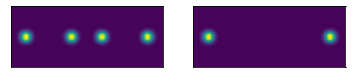

In [7]:
fig, axes = plt.subplots(1, 2)

plot_distribution(mus_full, sigma2, axes[0])
plot_distribution(mus_farthest, sigma2, axes[1])

In [8]:
def train(gamma, n_iterations, param_batch_size, log_p, dt=0.05):
    
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []
    
    for _ in tqdm(range(n_iterations)):
        optimizer.zero_grad()
        
        loss = relative_entropy_control_cost(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()
        
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    losses = np.array(losses)
    
    return sde, losses

In [9]:
gamma = 0.1
n_iterations = 5000
param_batch_size = 128

In [63]:
log_p_full = partial(log_p, mus_full, sigma2)
sde, losses = train(gamma, n_iterations, param_batch_size, log_p_full, dt=0.05)

  0%|                                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:39<00:00, 31.33it/s]


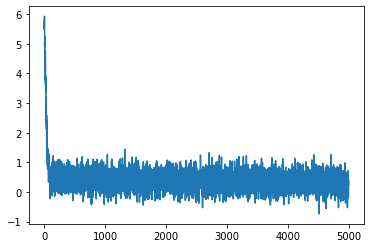

In [64]:
plt.plot(losses)

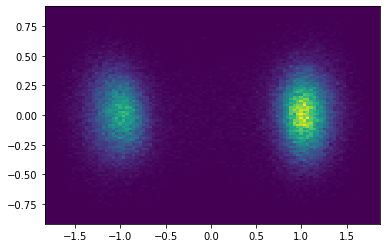

In [65]:
with torch.no_grad():
    samples_full = sde.sample(100000, dt=0.01, device=device)
    samples_full = samples_full.cpu().numpy()
plt.hist2d(samples_full[:, 0], samples_full[:, 1], bins=100);

In [66]:
log_p_full = partial(log_p, mus_farthest, sigma2)
sde, losses = train(gamma, n_iterations, param_batch_size, log_p_full, dt=0.05)

  0%|                                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:41<00:00, 31.03it/s]


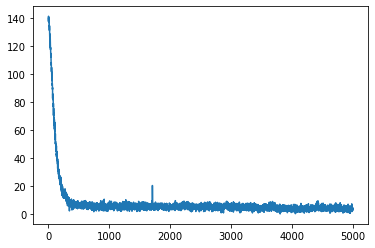

In [67]:
plt.plot(losses)

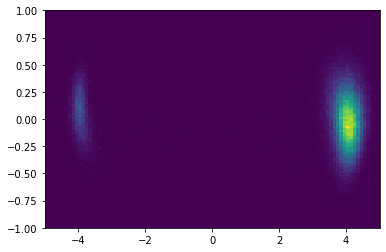

In [68]:
with torch.no_grad():
    samples_farthest = sde.sample(100000, dt=0.01, device=device)
    samples_farthest = samples_farthest.cpu().numpy()
plt.hist2d(samples_farthest[:, 0], samples_farthest[:, 1], bins=100, range=[[-5, 5], [-1, 1]]);

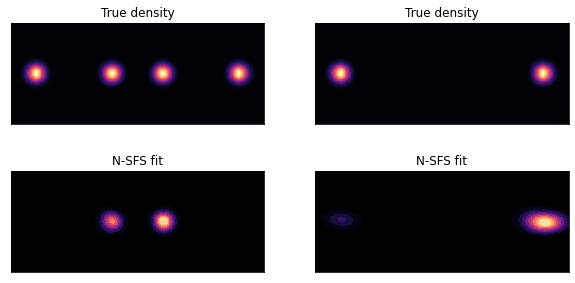

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

cmap = "magma"

plot_distribution(mus_full, sigma2, axes[0][0], cmap=cmap)
plot_distribution(mus_farthest, sigma2, axes[0][1], cmap=cmap)

axes[1][0].set_aspect("equal")
axes[1][0].set_facecolor("black")
axes[1][0].set_xlim(-5, 5)
axes[1][0].set_ylim(-2, 2)
sns.kdeplot(x=samples_full[:, 0], y=samples_full[:, 1], cmap=cmap, ax=axes[1][0], fill=True)
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])

axes[1][1].set_aspect("equal")
axes[1][1].set_facecolor("black")
axes[1][1].set_xlim(-5, 5)
axes[1][1].set_ylim(-2, 2)
sns.kdeplot(x=samples_farthest[:, 0], y=samples_farthest[:, 1], cmap=cmap, ax=axes[1][1], fill=True)
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])

axes[0][0].set_title("True density")
axes[0][1].set_title("True density")
axes[1][0].set_title("N-SFS fit")
axes[1][1].set_title("N-SFS fit")

fig.savefig("nsfs-modes.png", dpi=300, bbox_inches="tight")

In [10]:
def gaussian_kde(data, queries, h):
    N = data.shape[0]
    dists = torch.cdist(queries, data)**2
    kde = torch.logsumexp(-dists / (2 * h), 1) - 0.5 * np.log(2 * np.pi * h) - np.log(N)
    return kde

In [411]:
def pseudocount(data, queries, h):
    dists = torch.cdist(queries, data)**2
    B = torch.logsumexp(-dists / (2 * h), 1)
    B_pos = torch.clamp(B, min=0)
    B_neg = torch.clamp(B, max=0)
    
    mask = B > 0
    mask = mask.float()
    
    log_Ap1 = mask * (B + torch.log(torch.exp(-B_pos) + 1)) + (1 - mask) * torch.log(torch.exp(B_neg) + 1)
    
    
    N = data.shape[0]
    PG = log_Ap1 - B + np.log(N) - np.log(N + 1)
    
    return PG

In [87]:
x = torch.randn(4, 2).to(device)

In [88]:
x

tensor([[-0.3715,  1.0884],
        [ 0.5306, -0.5443],
        [-0.6213,  0.5324],
        [-0.3562, -1.0257]], device='cuda:0')

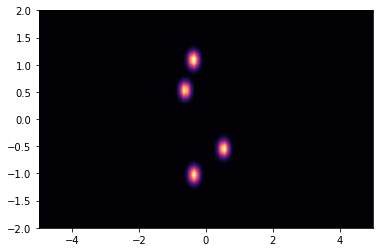

In [96]:
rng_x = torch.linspace(-5, 5, 100, device=device)
rng_y = torch.linspace(-2, 2, 100, device=device)
xx, yy = torch.meshgrid(rng_x, rng_y)
coords = torch.dstack([xx, yy])
coords = coords.reshape(-1, 2)
kde = gaussian_kde(x, coords, 0.01)
z = kde.reshape(100, 100)
z = torch.exp(z)
plt.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50, cmap=cmap)

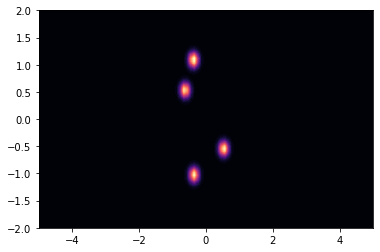

In [119]:
B = pseudocount(x, coords, 0.01)
z = B.reshape(100, 100)
plt.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50, cmap=cmap)

In [691]:
def adjusted_target(old_samples, log_p, h):
    
    def func(samples):
        pc = pseudocount(old_samples, samples, h)
        return log_p(samples) + 100 * pc
    
    return func

In [692]:
def train_with_pseudocounts(gamma, n_iterations, param_batch_size, log_p, h=0.01, dt=0.05):
    
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []
    old_samples = None
    
    for i in tqdm(range(n_iterations)):
        
        if i == 0:
            target_func = log_p
        else:
            target_func = adjusted_target(old_samples, log_p, h)
            
        optimizer.zero_grad()
        
        loss, samples = relative_entropy_control_cost(sde, target_func, param_batch_size=param_batch_size, dt=dt, device=device, return_samples=True)
        samples = samples.detach()
        
        loss.backward()
        
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        
        if old_samples is None:
            old_samples = samples
        else:
            old_samples = torch.cat([old_samples, samples])
    
    losses = np.array(losses)
    
    return sde, losses

In [907]:
log_p_full = partial(log_p, mus_full, sigma2)
sde, losses = train_with_pseudocounts(gamma, 3000, param_batch_size, log_p_full, dt=0.05)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:03<00:00, 24.21it/s]


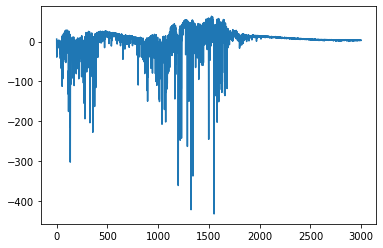

In [908]:
plt.plot(losses)

In [16]:
samples_pc

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

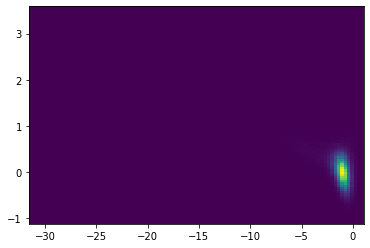

In [909]:
with torch.no_grad():
    samples_pc = sde.sample(100000, dt=0.01, device=device)
    samples_pc = samples_pc.cpu().numpy()
plt.hist2d(samples_pc[:, 0], samples_pc[:, 1], bins=100);

In [910]:
sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)

losses = []
old_samples = None
i=0
dt=0.05
h=0.01
log_p_full = partial(log_p, mus_full, sigma2)

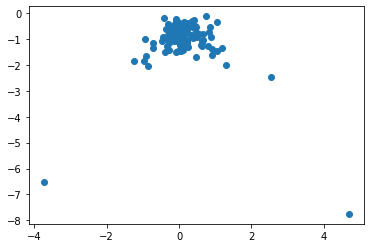

In [993]:
if i == 0:
    target_func = log_p_full
else:
    target_func = adjusted_target(old_samples, log_p_full, h)

optimizer.zero_grad()

loss, samples = relative_entropy_control_cost(sde, target_func, param_batch_size=param_batch_size, dt=dt, device=device, return_samples=True)
samples = samples.detach()

loss.backward()

optimizer.step()
losses.append(loss.detach().cpu().numpy())

if old_samples is None:
    old_samples = samples
else:
    old_samples = torch.cat([old_samples, samples])

i += 1

plt.scatter(samples[:, 0].detach().cpu(), samples[:, 1].detach().cpu())

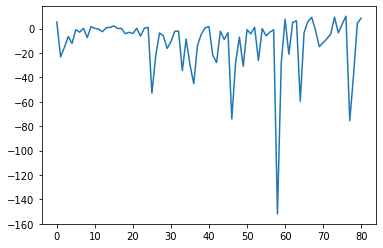

In [777]:
plt.plot(losses)

In [460]:
old_samples.shape

torch.Size([5888, 2])

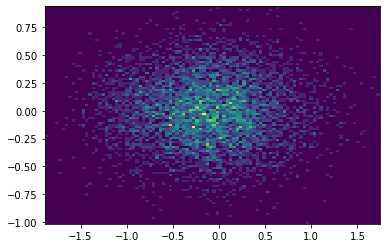

In [461]:
plt.hist2d(old_samples[:, 0].cpu().numpy(), old_samples[:, 1].cpu().numpy(), bins=100);

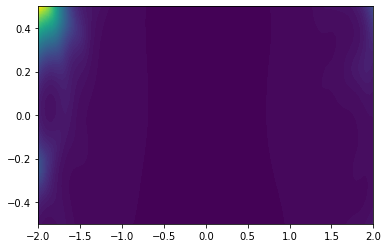

In [1000]:
rng_x = torch.linspace(-2, 2, 100, device=device)
rng_y = torch.linspace(-0.5, 0.5, 100, device=device)
xx, yy = torch.meshgrid(rng_x, rng_y)
coords = torch.dstack([xx, yy])
coords = coords.reshape(-1, 2)
z = target_func(coords)
z = z.reshape(100, 100)
plt.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=100)

In [410]:
z

tensor([[inf, inf, inf,  ..., inf, inf, inf],
        [inf, inf, inf,  ..., inf, inf, inf],
        [inf, inf, inf,  ..., inf, inf, inf],
        ...,
        [inf, inf, inf,  ..., inf, inf, inf],
        [inf, inf, inf,  ..., inf, inf, inf],
        [inf, inf, inf,  ..., inf, inf, inf]], device='cuda:0')